In [7]:
# importing dependencies
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

## Question 1 - QFT

$QFT_N$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$ where $x_1$ is the most significant bit, is given by:
$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} 
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} 
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} 
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
\end{aligned}
$$



Circuit Implementation of general n-qubit QFT

In [3]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Sample visualization
sample_qc = QuantumCircuit(4)
qft(sample_qc,4)
sample_qc.draw(fold=100)


┌───┐   
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├─X─
           │                               │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X───┼─
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │   │ 
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X───┼─
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                      │ 
q_3: ┤ H ├─■────────■────────■──────────────────────────────────────────────────X─
     └───┘

Testing 4-qubit QFT on x = 0 should output Hadamard transform of x

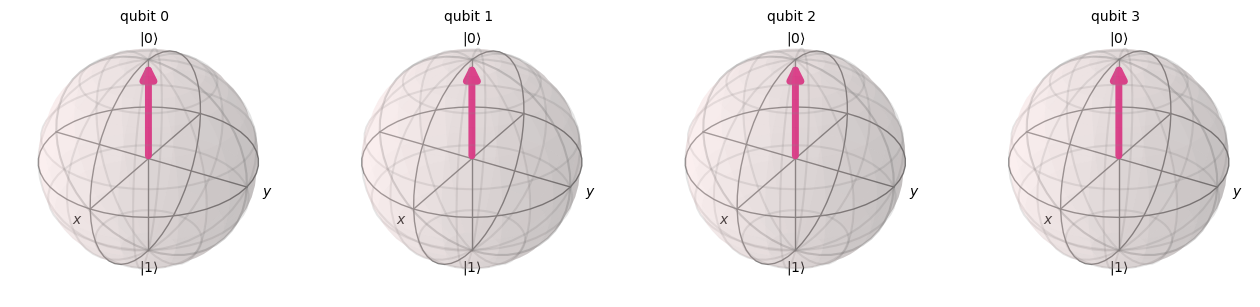

In [4]:
# Create the circuit
qc = QuantumCircuit(4)

# Plotting initial zeros vector
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [5]:
qft(qc,4)
qc.draw(fold=100)

┌───┐   
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├─X─
           │                               │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X───┼─
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │   │ 
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X───┼─
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                      │ 
q_3: ┤ H ├─■────────■────────■──────────────────────────────────────────────────X─
     └───┘

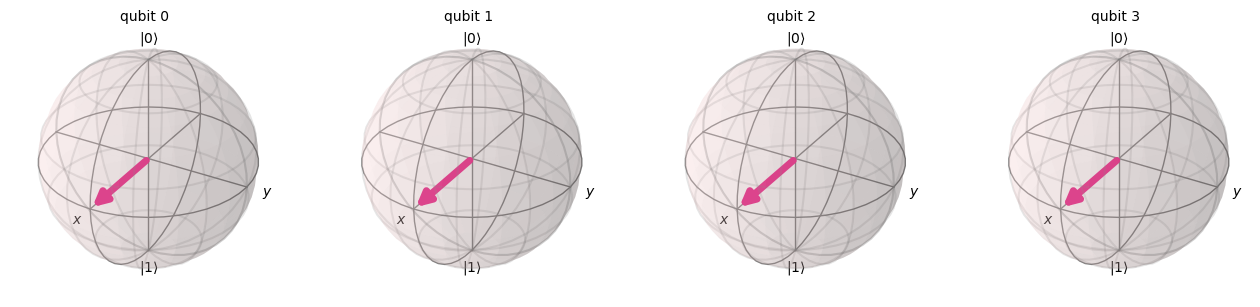

In [6]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

# We obtain the appropriate |++++> state, as seen in the bloch_multivector plot below

## Question 2 - Deutsch-Jozsa algorithm

### Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant. 

Note that the Deutsch-Jozsa problem is an $n$-bit extension of the single bit Deutsch problem. 

### Quantum Solution <a id='quantum-solution'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. 
Now, let's go through the steps of the algorithm:

1. Prepare two quantum registers. The first is an $n$-qubit register initialized to $|0\rangle$, and the second is a one-qubit register initialized to $|1\rangle$:
        
   $$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$

2. Apply a Hadamard gate to each qubit:
        
   $$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$

3. Apply the quantum oracle $\vert x\rangle \vert y\rangle$ to $\vert x\rangle \vert y \oplus f(x)\rangle$:
   $$
   \begin{aligned}
   \lvert \psi_2 \rangle  
   & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
   & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
   \end{aligned}
   $$
       
   since for each $x,f(x)$ is either $0$ or $1$.

4. At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register:
    $$
    \begin{aligned}
        \lvert \psi_3 \rangle 
            & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                \vert y \rangle \right] \\
            & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                \vert y \rangle
    \end{aligned}
    $$
       
   where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.

5. Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced. 

### Worked Example  <a id='example'></a>

For the given two bit function: $f(x,y)=x + xy$ such that 

$f(0,0)=0$

$f(0,1)=0$

$f(1,0)=1$

$f(1,1)=1$

We see that f(x,y) is a balanced function.

The corresponding phase oracle of this two-bit oracle is $U_f \lvert x_1, x_0 \rangle = (-1)^{f(x_1, x_0)}\lvert x \rangle$

We will now check if this oracle works as expected by taking a example state
$$\lvert \psi_0 \rangle = \lvert 0 0 \rangle_{01} \otimes \lvert 1 \rangle_{2} $$

1. The first register of two qubits is initialized to $|00\rangle$ and the second register qubit to $|1\rangle$ 
        
   (Note that we are using subscripts 0, 1, and 2 to index the qubits. A subscript of "01" indicates the state of the register containing qubits 0 and 1)

   $$\lvert \psi_0 \rangle = \lvert 0 0 \rangle_{01} \otimes \lvert 1 \rangle_{2} $$

2. Apply Hadamard on all qubits
   
   $$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle + \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{01} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2}  $$

3. Applying oracle and simplifying, we get the following: 
   $$
   \begin{aligned}
   \lvert \psi_2 \rangle & = \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{01} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2} + \lvert 0 1 \rangle_{01} \otimes \left( \lvert 0 \rangle - \lvert  1 \rangle \right)_{2} - \lvert 1 0 \rangle_{01} \otimes \left( \lvert 0  \rangle - \lvert 1 \rangle \right)_{2} - \lvert 1 1 \rangle_{01} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2}  \right] \\
       & = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle - \lvert 1 0 \rangle - \lvert 1 1 \rangle \right)_{01} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2} \\
       & = \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{0} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle + \lvert 1 \rangle \right)_{1} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2}
   \end{aligned}
   $$

5. Apply Hadamard on the first register
   
   $$ \lvert \psi_3\rangle = \lvert 1 \rangle_{0} \otimes \lvert 0 \rangle_{1} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2} $$

6. Measuring the first two qubits will give the non-zero $01$, indicating a balanced function.

In [15]:
# CREATING THE ORACLE

n = 2
balanced_oracle = QuantumCircuit(n+1)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gate obtained by simplifying f = x + xy to f = x
balanced_oracle.cx(0, n)

balanced_oracle.barrier()
balanced_oracle.draw()

░       ░ 
q_0: ─░───■───░─
      ░   │   ░ 
q_1: ─░───┼───░─
      ░ ┌─┴─┐ ░ 
q_2: ─░─┤ X ├─░─
      ░ └───┘ ░

In [17]:
# CREATING THE FULL DJ CIRCUIT

dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put output qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()



┌───┐      ░       ░ ┌───┐ ░ ┌─┐   
q_0: ┤ H ├──────░───■───░─┤ H ├─░─┤M├───
     ├───┤      ░   │   ░ ├───┤ ░ └╥┘┌─┐
q_1: ┤ H ├──────░───┼───░─┤ H ├─░──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐ ░ └───┘ ░  ║ └╥┘
q_2: ┤ X ├┤ H ├─░─┤ X ├─░───────░──╫──╫─
     └───┘└───┘ ░ └───┘ ░       ░  ║  ║ 
c: 2/══════════════════════════════╩══╩═
                                   0  1

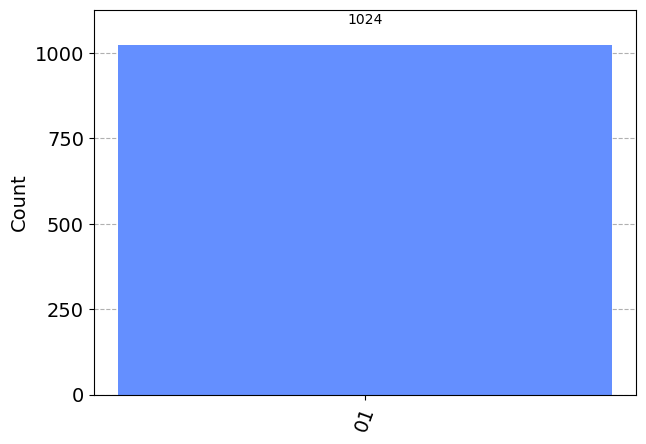

In [18]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

In [19]:
# ...we have a 0% chance of measuring 000. 
assert answer.get('00', 0) == 0

## Question 3 - Phase estimation


This circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

i. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$: 



$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$

 

ii. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register: 



$$ |\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$



iii. **Controlled Unitary Operations**: We need to introduce the controlled unitary $CU$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operator with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: 



$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$



Applying all the $n$ controlled operations $CU^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

$$
\begin{aligned}
|\psi_{2}\rangle & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
$$

where $k$ denotes the integer representation of n-bit binary numbers. 

iv. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform. Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the auxiliary register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$ 

v. **Measurement**: 
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the auxiliary register with high probability: 



$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$



For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$

**S-gate analysis**: 

For the $S$-gate, we use Quantum Phase Estimation to estimate its phase. The $S$-gate adds a phase of $e^\frac{i\pi}{2}$ to the state $|1\rangle$:

$$ S|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{2}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{2}|1\rangle $$

Since QPE will give us $\theta$ where:



$$ S|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{4}$$



In this example we will use three qubits and obtain an _exact_ result.

In [10]:
# Initializing eigenvector qubit to |1>
qpe = QuantumCircuit(4, 3)
qpe.x(3)

# Hadamard transform
for qubit in range(3):
    qpe.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(np.pi/2, counting_qubit, 3); # controlled-S
    repetitions *= 2 # used to generate U^2^j phase kickbacks

qpe.barrier()
# Apply inverse QFT
qpe = qpe.compose(QFT(3, inverse=True), [0,1,2])
qpe.barrier()

# Measure
for n in range(3):
    qpe.measure(n,n)

qpe.draw(fold=200)

┌───┐                                                                ░ ┌──────────┐ ░ ┌─┐      
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░─┤0         ├─░─┤M├──────
     ├───┤ │                                                              ░ │          │ ░ └╥┘┌─┐   
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░─┤1 IQFT_dg ├─░──╫─┤M├───
     ├───┤ │        │        │                                            ░ │          │ ░  ║ └╥┘┌─┐
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░─┤2         ├─░──╫──╫─┤M├
     ├───┤ │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  │P(π/2)  ░ └──────────┘ ░  ║  ║ └╥┘
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░──────────────░──╫──╫──╫─
     └───┘                                                                ░              ░  ║  ║  ║ 
c: 3/═══════════════════════════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                                            0  1  2

Results

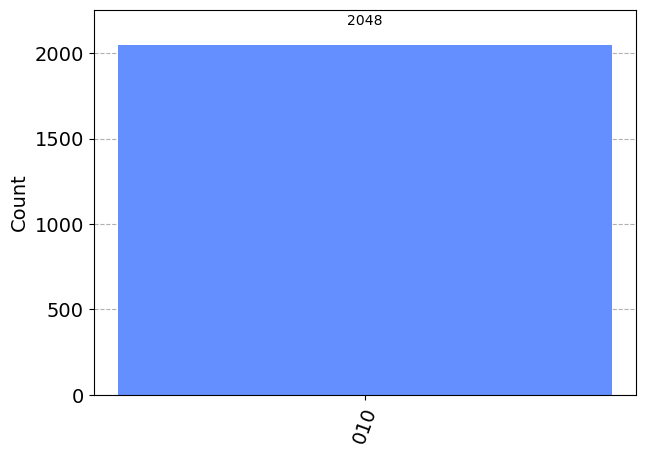

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result (`010`) with certainty, which translates to the decimal: `2`. We now need to divide our result by $2^n$ to get $\theta$:
$$ \theta = \frac{2}{2^3} = \frac{1}{4} $$


Credits: The essential part of the algorithms was learned from qiskit/textbook guide 
https://github.com/Qiskit/textbook/tree/main